In [4]:
import torch
# import tenseal as ts
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
# from openfhe import *
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression as SklearnLR

# from concrete import fhe
# from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer
from concrete.ml.sklearn import SGDClassifier

# from concrete.ml.sklearn import LogisticRegression as ZamaLR


Setul de date este luat din kaggle: https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data si este procesat in notebook-ul data/process_data.ipynb pentru usurinta.

Codul se poate rula integral prin optiunea "Run All" a notebook-ului

In [5]:
def load_data(path):
    date_salvate = torch.load(path,weights_only=True)
    x_train = date_salvate['train_data']
    x_test = date_salvate['test_data']
    y_train = date_salvate['train_labels']
    y_test = date_salvate['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [6]:
def normalize_data(x_train,x_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    return x_train,x_test


In [4]:
x_train,x_test,y_train,y_test = load_data('../../data/date_logistic_regression.pth')
x_train,x_test= normalize_data(x_train,x_test)
x_train,x_test,y_train,y_test= x_train[:1000],x_test[:700],y_train[:1000],y_test[:700]
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul,
#  deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [17]:
def save_model(model, file_path):
    pickle.dump(model, open(file_path, "wb"))

In [6]:
t_start = time.perf_counter()
sklearn_model = SklearnLR(random_state=42, verbose=True).fit(x_train,y_train.ravel())
t_end = time.perf_counter()

print(f"Antrenarea modelului pe datele clare cu biblioteca Sklearn a durat: {(t_end - t_start):.20f} secunde")

Antrenarea modelului pe datele clare cu biblioteca Sklearn a durat: 0.23832363100018483237 secunde


In [7]:
def metrics_on_clear_data(model, x, y, biblioteca):
    t_start = time.perf_counter()
    predictions = model.predict(x)
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")
    correct = torch.abs(y - predictions.reshape(-1, 1)) < 0.5
    correct= correct.float().mean()
    print(f"Acuratetea pe setul de date necriptate: {correct}")
    binary_preds = (np.array(predictions) > 0.5).astype(int)
    cm = confusion_matrix(y_test, binary_preds,  labels=[0, 1])
    plt.figure(figsize=(8,6))
    sns.set_style("dark")
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=['Fără risc', 'Cu risc crescut'], yticklabels=[ 'Fără risc', 'Cu risc crescut'],linewidth=.5)
    plt.xlabel('Predicții')
    plt.ylabel('Valori reale')
    plt.title(f'Model antrenat pe date clare predictii pe date clare {biblioteca}')
    plt.legend(title=f'Acuratete: {correct:.4f}', title_fontsize=12)
    plt.savefig(f'../../plots/logistic_regression/lo_r_trained_on_clear_data_confusion_matrix_on_clear_data_{biblioteca}.png')
    plt.show()

Predictiile pe testul de date necriptate au durat:0.00829811899984633783 secunde
Acuratetea pe setul de date necriptate: 0.9857142567634583


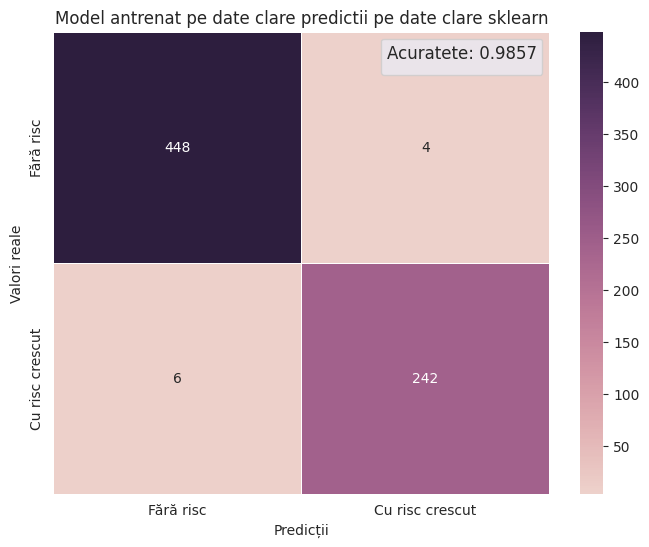

In [8]:
metrics_on_clear_data(sklearn_model,x_test,y_test, 'sklearn')

In [9]:
t_start = time.perf_counter()
y_train = y_train.to(torch.int).ravel()
zama_model = ZamaLR(n_bits=8, verbose=True)
zama_model.fit(x_train, y_train)
t_end = time.perf_counter()

print(f"Antrenarea modelului pe datele clare cu biblioteca Zama a durat: {(t_end - t_start):.20f} secunde")

Antrenarea modelului pe datele clare cu biblioteca Zama a durat: 0.54194137600006797584 secunde


Predictiile pe testul de date necriptate au durat:0.00408945699973628507 secunde
Acuratetea pe setul de date necriptate: 0.9842857122421265


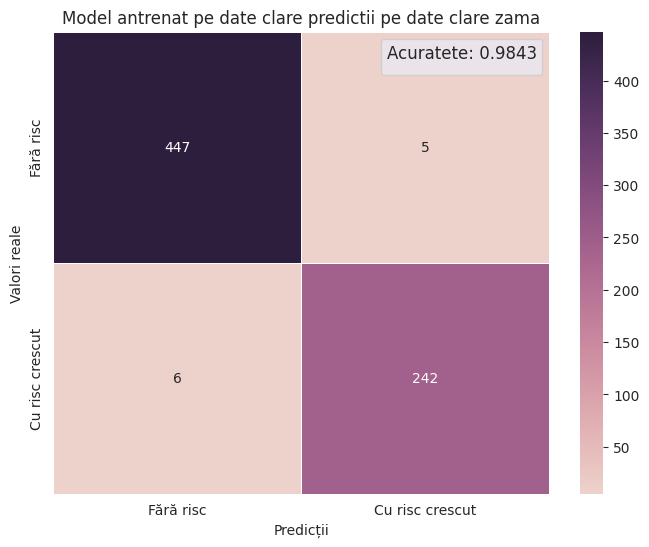

In [10]:
metrics_on_clear_data(zama_model,x_test,y_test, 'zama')

In [12]:
def metrics_on_encrypted_data(model, x_test,x_train, y):
    #generam criptocontextul
    fhe_schema = model.compile(x_train)
    fhe_schema.client.keygen(force=False)
    t_start = time.perf_counter()
    predictions = model.predict(x_test, fhe="execute")
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date criptate au durat:{(t_end - t_start):.20f} secunde")
    encrypted_accuracy = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions,  labels=[0, 1])
    plt.figure(figsize=(8,6))
    sns.set_style("dark")
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=['Fără risc', 'Cu risc crescut'], yticklabels=[ 'Fără risc', 'Cu risc crescut'],linewidth=.5)
    plt.xlabel('Predicții')
    plt.ylabel('Valori reale')
    plt.title(f'Model antrenat pe date clare predictii pe date criptate ')
    plt.legend(title=f'Acuratete: {encrypted_accuracy:.4f}', title_fontsize=12)
    plt.savefig(f'../../plots/logistic_regression/lo_r_trained_on_clear_data_confusion_matrix_on_encrypted_data.png')
    plt.show()

Predictiile pe testul de date criptate au durat:19.29562088000011499389 secunde


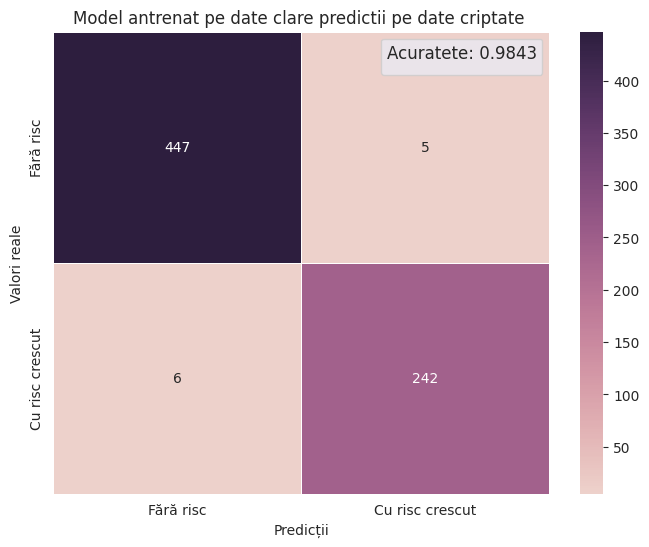

In [13]:
metrics_on_encrypted_data(zama_model,x_test,x_train, y_test)

In [7]:
x_train,x_test,y_train,y_test = load_data('/kaggle/input/datasetzama/date_logistic_regression.pth')
x_train,x_test= normalize_data(x_train,x_test)
x_train,x_test,y_train,y_test= x_train[:1000],x_test[:700],y_train[:1000],y_test[:700]
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul,
#  deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [8]:
x_test_zama = x_test[:700].detach().numpy()
y_test_zama = y_test[:700].detach().numpy()
x_train_zama = x_train[:1000].detach().numpy()
y_train_zama = y_train.to(torch.int).ravel()
y_train_zama = y_train_zama[:1000].detach().numpy()
print(x_test_zama.shape)
print(type(y_train_zama[0]))

(700, 16)
<class 'numpy.int32'>


In [9]:
parameters_range = (-1.0, 1.0)
N_ITERATIONS = 20
RANDOM_STATE = 42
model_binary_fhe = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
    verbose=True,
)

# Fit on encrypted data
y_train_zama=y_train_zama.flatten()
t_start = time.perf_counter()
model_binary_fhe.fit(x_train_zama, y_train_zama, fhe="execute")
t_end = time.perf_counter()

print(f"Antrenarea modelului pe datele criptate cu biblioteca Zama a durat: {(t_end - t_start):.20f} secunde")


Compiling training circuit on device 'cpu'...
Compilation took 5.9868 seconds.
Key Generation...
Key generation took 80.9770 seconds.
Training on encrypted data...
Iteration 0 took 137.47 seconds.
Iteration 1 took 109.22 seconds.
Iteration 2 took 108.25 seconds.
Iteration 3 took 107.28 seconds.
Iteration 4 took 106.95 seconds.
Iteration 5 took 116.82 seconds.
Iteration 6 took 107.25 seconds.
Iteration 7 took 106.36 seconds.
Iteration 8 took 107.09 seconds.
Iteration 9 took 106.42 seconds.
Iteration 10 took 111.77 seconds.
Iteration 11 took 107.68 seconds.
Iteration 12 took 108.21 seconds.
Iteration 13 took 108.29 seconds.
Iteration 14 took 107.99 seconds.
Iteration 15 took 108.45 seconds.
Iteration 16 took 112.48 seconds.
Iteration 17 took 107.97 seconds.
Iteration 18 took 108.54 seconds.
Iteration 19 took 108.18 seconds.
Antrenarea modelului pe datele criptate cu biblioteca Zama a durat: 2291.97838165000030130614 secunde


In [10]:
def metrics_zama():
    predictions_clear = model_binary_fhe.predict(x_test_zama)
    accuracy_clear = accuracy_score(y_test_zama, predictions_clear)
    cm = confusion_matrix(y_test_zama, predictions_clear,  labels=[0, 1])
    plt.figure(figsize=(8,6))
    sns.set_style("dark")
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=['Fără risc', 'Cu risc crescut'], yticklabels=[ 'Fără risc', 'Cu risc crescut'],linewidth=.5)
    plt.xlabel('Predicții')
    plt.ylabel('Valori reale')
    plt.title(f'Model antrenat pe date criptate predictii pe date clare ')
    plt.legend(title=f'Acuratete: { accuracy_clear:.4f}', title_fontsize=12)
    plt.savefig('lo_r_trained_on_encrypted_data_confusion_matrix_on_clear_data.png')
    plt.show()
    
    model_binary_fhe.compile(x_test_zama)
    
    predictions_enc = model_binary_fhe.predict(x_test_zama, fhe="execute")
    
    accuracy_enc = accuracy_score(y_test_zama, predictions_enc)
    cm = confusion_matrix(y_test_zama, predictions_enc,  labels=[0, 1])
    plt.figure(figsize=(8,6))
    sns.set_style("dark")
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=['Fără risc', 'Cu risc crescut'], yticklabels=[ 'Fără risc', 'Cu risc crescut'],linewidth=.5)
    plt.xlabel('Predicții')
    plt.ylabel('Valori reale')
    plt.title(f'Model antrenat pe date criptate predictii pe date criptate ')
    plt.legend(title=f'Acuratete: {accuracy_enc:.4f}', title_fontsize=12)
    plt.savefig('lo_r_trained_on_encrypted_data_confusion_matrix_on_encrypted_data.png')
    plt.show()

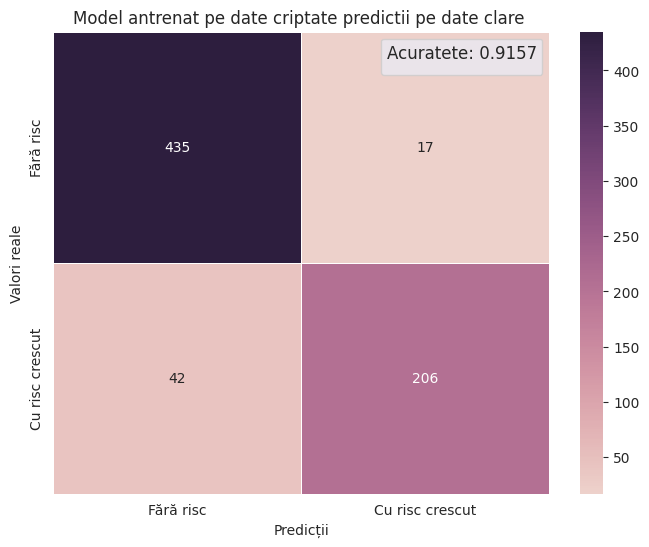

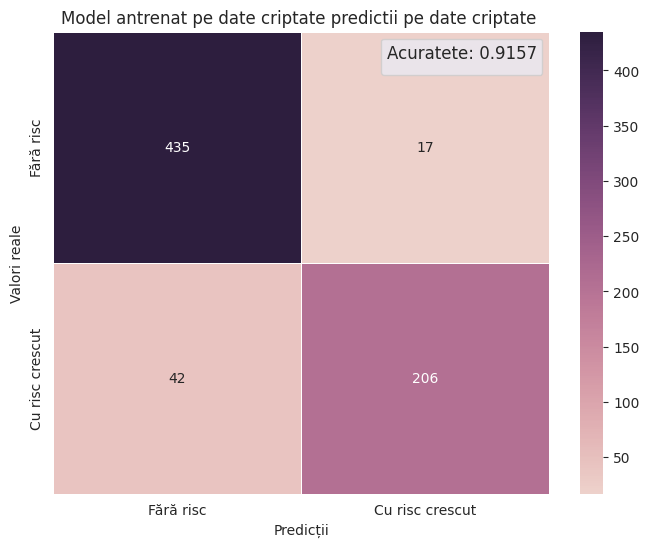

In [11]:
metrics_zama()